<a href="https://colab.research.google.com/github/spatialtopology/spacetop-prep/blob/master/spacetop_prep/physio/walkthrough_p01_grouplevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/18406041/195505977-bfbf8e61-32d2-4ac7-b23d-192abde3dd1f.png" alt="drawing"  width = "400" align="right" hspace="0px" vspace="0px"/>


# Physio analysis with Neurokit: p01_grouplevel.py



#### To navigate, simply click on a cell and hit Shift + Enter.

**The purpose of this notebook is to demonstrate:**
1.   Which set of functions to use for preprocessing physio data
2.   Which set of functions to use for extracting SCR and SCL responses
3.   A demonstration of an analysis (the effect of stimulus intensity on skin conductance response)

<!-- 

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" > -->


In [1]:
__author__ = "Heejung Jung, Isabel Neumann, Yaroslav Halchenko"
__copyright__ = "Spatial Topology Project"
__credits__ = [""] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung.gr@dartmouth.edu"
__status__ = "Development"

If you encounter bugs, have any questions, or comments, please raise an issue in our GitHub repository: https://github.com/jungheejung/spacetop_biopac

### Import packages 


In [ ]:
!pip install neurokit2
!pip install bioread
!pip install matplotlib

## 1.Git clone and pip install spacetop_prep

> This is a necessary step in order to use the utils functions under the spacetop_prep module. Make sure to run the `python setup` and `pip install` if you've cloned the repository on your local machine 😉

In [4]:
!git clone https://github.com/spatialtopology/spacetop-prep.git

Cloning into 'spacetop-prep'...
remote: Enumerating objects: 1884, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 1884 (delta 306), reused 288 (delta 200), pack-reused 1470
Receiving objects: 100% (1884/1884), 6.53 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (1271/1271), done.


In [ ]:
!cd /content/spacetop-prep
# setup and pip install spacetop_prep
!python setup.py sdist
!pip install -e .

In [82]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
from pathlib import Path
from os.path import join
import itertools
from statistics import mean

plt.rcParams['figure.figsize'] = [25, 15]  # Bigger images
plt.rcParams['font.size']= 14

%matplotlib inline

In [9]:
from spacetop_prep.physio import utils

---

## 2.Load data in demo directory
> Two files are saved in the demo folder for this walkthrough
* physio.tsv
* beh.csv

In [23]:
os.chdir('/content/spacetop-prep/spacetop_prep/physio')
pwd = os.getcwd()

In [24]:
demo_dir = join(pwd, 'demo', 'data', 'physio03_bids')
physio_fname = 'sub-0051_ses-01_task-cue_run-02-pain_recording-ppg-eda-trigger_physio.tsv'
sub = utils.initialize.extract_bids(physio_fname, 'sub')
ses = utils.initialize.extract_bids(physio_fname, 'ses')
run = utils.initialize.extract_bids(physio_fname, 'run')
physio_fpath = join(demo_dir, sub, ses, physio_fname)
beh_fname = glob.glob(join(demo_dir, sub, ses, f"{sub}_{ses}_task-social_{run}*_beh.csv"), recursive = True)[0]

['sub-0051']
['ses-01']
['run-02-pain']


In [106]:
print(">>> load physio data...")
physio_df = pd.read_csv(physio_fpath, sep='\t')
print(">>> check physio data columns: ",physio_df.columns)

beh_df = pd.read_csv(beh_fname)

>>> load physio data...
>>> check physio data columns:  Index(['physio_eda', 'physio_ppg', 'trigger_mri', 'trigger_heat',
       'event_experimentduration', 'event_fixation', 'event_cue',
       'event_expectrating', 'event_stimuli', 'event_actualrating'],
      dtype='object')


### set necessary parameters

In [61]:
# do you want the first TTL? (when the stimulus start ramping up) 
# OR do you want the 2nd TTL? (when the stimulus hits the intended temperature and starts plateau)
ttl_index = 2 
samplingrate = 2000

## +Note about data structure






<img src="https://github.com/spatialtopology/spacetop-prep/blob/master/spacetop_prep/physio/.visual/physio_data_example.png?raw=true" alt="drawing"  width = "400" align="right" hspace="0px" vspace="0px"/>


> As you can see from the image on the right, we have a number of channels recorded in this physio file.<br><br>
> ***Description of the channels***<br><br>
**A. Two Physio channels (analog; 1st, 2nd channel)**
1.   **`physio_eda`** Skin  Conductance (EDA)
2.   **`physio_ppg`** Pulse (PPG)
<br>
**B. TTL channels (3rd, 4th channel)**
1.   **`trigger_mri`**: TTl signals from the radio-frequency (RF) pulses, recorded in columns. In this study, we would have a TTL for every .46 sec.
2.   **`trigger_heat`**: Only for pain runs. We recorded the TTL signals for every pain stimulus. 1) initiation of pain stimulus 2) time it reached intended temperature (beginning of plateau), 3) time it terminated intended termperature (end of pleateau), and 4) return to baseline temperatuer of 32 degrees
<br>
**C. Digital channels (last 6 channels)**<br> 
* we toggled the channels whenever  MATlab-stim PC transitioned to a new event. In other words, we have boxcar signals for whenever an event was displayed on screen.
1.   **`event_experimentduration`**: when the experiment started/finished, i.e. one boxcar for duration of experiment
2.   **`event_fixation`**: when the fixation was present on screen
3.   **`event_cue`**: when the cue was present on screen (1s per trial, 2 levels of high vs. low)
4.   **`event_expectrating`**: when the participant saw the "expect" keyword until they rated their expectation ratings for the upcoming stimulus
5.   **`event_stimuli`**: when the participant undergoes the stimulus delivery (5s per trial; 9s for pain run, 5s plateau; 3 levels of high vs. med vs. low stimulus intensity)
6.   **`event_actualrating`**:  when the participant saw the "actual" keyword until they rated their actual ratings for the experienced stimulus



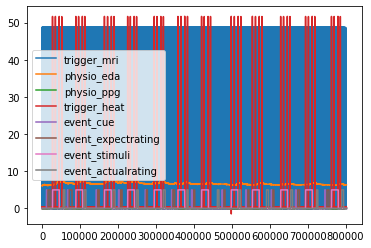

In [27]:
physio_df[['trigger_mri', 'physio_eda', 'physio_ppg', 'trigger_heat',
           'event_cue', 'event_expectrating', 'event_stimuli', 'event_actualrating']].plot()

## 3.Baseline correction 💻 utils.preprocess.baseline_correct

> #### **Significance of baseline correction:**<br>
Baseline correction is important when using interval related analyses. For instance, we might want to compare the average signal difference between a pain run vs. a cognitive run. This is when we would use interval-related analayses. The signals extend for a longer time period, which makes baseline correction imperative. Only after correct baseline correction can we check the overall signal difference. <br>
> #### **Methods of baseline correction:**
1.   **Method 1** subtract mean baseline, using the 6 TRs
2.   **Method 2** using the fixation period from the entire run
3.   **Method 3** using the fixation period from corresponding trial
* Ideally, **Method 3** is the way to go for baseline correction. However, for simplicity, in this notebook, we'll use **Method 2**, which collapses all of the fixation periods into one bin. We average these signals and subtract it from the main EDA signal. 


In [ ]:
physio_df_bl = utils.preprocess.baseline_correct(
    df=physio_df, raw_eda_col='physio_eda', baseline_col='event_fixation')

> Now, we have a new dataframe with a baseline corrected column. 
* Whenever you use the preprocess.baseline_correct function, you will input a `raw_eda_col`. 
* Then, this function will create a new column by appending `_blcorrect` to the inputted column<br>

> 🎨 the plot below demonstrates what a baseline correction does to the signal

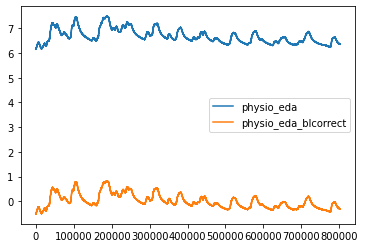

In [32]:
physio_df_bl[['physio_eda', 'physio_eda_blcorrect']].plot()

## 4.Neurokit event extraction 💻 `preprocess._binarize_channel` & `preprocess.identify_boundary`

> #### **Here's how we extract events-of-interest onsets & time-locked physiological signals.** 
* The idea is that we **(1) binarize the signals** and **(2) detect transitions** of these binary values. 
* We can extract the indices of when the cue event starts and when they stop.

>#### **We use two functions:**
1.   `binarize_channel`
2.   `identify_boundary`
* The output is dictionary that houses all of the events. (In this experiment, we have 4 events of interest)
* **What a user needs to do**: change the dict_channel. In case you have column names that you want to change, you can feed in a `dict_channel` in the structure of {`old column name`: `new column name`}

In [46]:
print(utils.preprocess.binarize_channel.__doc__)


    Function binarizes signals from biopac digital channels.
    If an explicit threshold value is provided, the signals are binarized based on this input.
    If not, the implicit threshold will default to the midpoint of the min/max values of the channel.

    Parameters
    ----------
    df: pandas dataframe
        acquisition file loaded into pandas using nk.read_acqknowledge.
    source_col: str
        column name of df that contains raw signal
    new_col: str
        new column name for saving binarized source_col values. (prevent from overwritting original data)
    threshold: int
        threshold for binarizing values within pandas column
    binary_high, binary_low: int
        minimum and maximum value for binarizing signal
        e.g. binary_high = 5, binary_low = 0
             or binary_high = 1, binary_low = 0

    Returns
    -------
    dataframe with new_col, which consists of binary values.

    For example:
        mid_val = (np.max(run_df['expect']) - np.min(

In [39]:
dict_channel = {'event_cue': 'event_cue',
'event_expectrating': 'event_expectrating',
'event_stimuli': 'event_stimuli',
'event_actualrating': 'event_actualrating',
}
dict_onset = {}
for i, (key, value) in enumerate(dict_channel.items()):
    dict_onset[value] = {}
    
    utils.preprocess.binarize_channel(physio_df_bl,
                                    source_col=key,
                                    new_col=value,
                                    threshold=None,
                                    binary_high=5,
                                    binary_low=0)
    dict_onset[value] = utils.preprocess.identify_boundary(physio_df_bl, value)



In [40]:
print(f"cue event: {dict_onset['event_cue']}")
print(f"expect rating event: {dict_onset['event_expectrating']}")
print(f"stimuli event: {dict_onset['event_stimuli']}")
print(f"actual rating event: {dict_onset['event_actualrating']}")

cue event: {'start': [11400, 66800, 142200, 201399, 271608, 341200, 393799, 474000, 536600, 603800, 667801, 745000], 'stop': [13356, 68756, 144156, 203356, 273557, 343156, 395756, 475956, 538556, 605756, 669756, 746956]}
expect rating event: {'start': [15409, 71398, 146798, 206998, 275005, 344798, 399799, 479398, 542605, 608398, 673799, 750998], 'stop': [21045, 78899, 150465, 210882, 277740, 349500, 402467, 482199, 545340, 611099, 678799, 756366]}
stimuli event: {'start': [27570, 89089, 164448, 225651, 295628, 358056, 420425, 498664, 554427, 629024, 694480, 762861], 'stop': [45356, 106956, 182356, 243556, 313557, 375956, 438356, 516556, 572356, 646956, 712356, 780756]}
actual rating event: {'start': [55798, 110797, 186605, 249398, 319398, 381799, 461998, 518598, 591399, 655399, 723206, 789399], 'stop': [59932, 115765, 192308, 253665, 324598, 384780, 466210, 523499, 596932, 660316, 726874, 794766]}


> If you're curious: 👀 Here's some example code on how we extract events from the physiological signals. 
* The idea is that we (1) binarize the signals and (2) detect transitions of these binary values. 
* We can extract the indices of when the cue event starts and when they stop.
* We'll use the **cue** channel as an example. 

> You can totally SKIP this cell 😉

In [36]:
mid_val = (np.max(physio_df_bl['event_cue']) - np.min(physio_df_bl['event_cue']))/2
physio_df_bl.loc[physio_df_bl['event_cue'] > mid_val, 'event_cue'] = 5
physio_df_bl.loc[physio_df_bl['event_cue'] <= mid_val, 'event_cue'] = 0

start_cue = physio_df_bl[physio_df_bl['event_cue'] > physio_df_bl[ 'event_cue'].shift(1)]
stop_cue = physio_df_bl[physio_df_bl['event_cue'] < physio_df_bl[ 'event_cue'].shift(1)]
print(f"* indices of cue events' start point 'start_cue': \n\t{start_cue.index}")
print(f"* indices of cue events' end point: 'stop_cue': \n\t{stop_cue.index}")

cue_freq = len(start_cue)
print(f"* total number of trials: {cue_freq}")

* indices of cue events' start point 'start_cue': 
	Int64Index([ 11400,  66800, 142200, 201399, 271608, 341200, 393799, 474000,
            536600, 603800, 667801, 745000],
           dtype='int64')
* indices of cue events' end point: 'stop_cue': 
	Int64Index([ 13356,  68756, 144156, 203356, 273557, 343156, 395756, 475956,
            538556, 605756, 669756, 746956],
           dtype='int64')
* total number of trials: 12


## 5.TTL extraction 💻 `utils.ttl_extraction.ttl_extraction`

Extract TTLs based on **TTL column** and event boundaries

> #### **We need to use a slightly different method. Here's the problem space:**<br>
* There are 4 TTLs for each trial. 
* The problem is, sometimes, TSA2 fails. There could be 3, there could be 1 TTL per trial in the case of this failure. Therefore... extracting TTLs becomes difficult, because we need to identify which TTL belongs to which trial. 

> #### **Solution:**<br>
One way to deal with this problem is to set event boundaries. 
* We know that the stimulus delivery period is sandwiched in between an expectation rating and an actual rating. 
* We'll use these time periods to figure out whether a TTL belongs to this trial vs. not. 
* We'll be using variables such as 'expect_start' and 'actual_end' as our event boundaries.

##### 5.1 first build a dataframe to store the extracted TTLs

In [47]:
import logging
logger = logging.getLogger()

# TODO: heejung, insert a diagram that describes before ttl and after ttl

In [48]:
dict_beforettl = dict_onset['event_expectrating']
dict_afterttl = dict_onset['event_actualrating'] 
dict_stimuli = dict_onset['event_stimuli']

In [49]:
final_df = pd.DataFrame()

In [50]:
#At this point, we need the metadata from the behavioral files:
metadata_df = beh_df[[
    'src_subject_id', 'session_id', 'param_task_name', 'param_run_num',
    'param_cue_type', 'param_stimulus_type', 'param_cond_type', 'event02_expect_RT', 'event02_expect_angle', 'event04_actual_RT', 'event04_actual_angle'
]]


In [77]:
nan_index, metadf_dropNA, plateau_start = utils.ttl_extraction.ttl_extraction(
    physio_df=physio_df_bl,
    dict_beforettl=dict_onset['event_expectrating'],
    dict_afterttl=dict_onset['event_actualrating'],
    dict_stimuli=dict_onset['event_stimuli'],
    samplingrate=2000,
    metadata_df=metadata_df,
    ttl_index=2
)
event_stimuli = {
    'onset': np.array(plateau_start).astype(pd.Int64Dtype),
    'duration': np.repeat(samplingrate * 5, len(plateau_start)),
    'label': np.array(np.arange(len(plateau_start))),
    'condition': metadf_dropNA['param_stimulus_type'].values.tolist()
}

In [74]:
plateau_start

array([35281.0, 96326.0, 172677.0, 232760.0, 303206.0, 366186.0, 427588.0,
       506862.0, 562514.0, 636568.0, 702121.0, 769943.0], dtype=object)

> 🎨 Let's check alignment with physio data and TTL signal, now housed in `event_stimuli`. The extracted onset from event_stimuli aligns nicely with the 2nd TTLs.

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


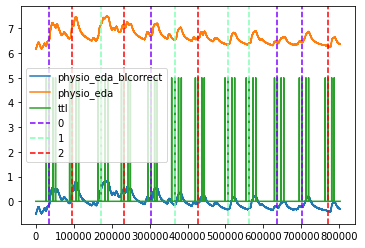

In [78]:
plot = nk.events_plot(event_stimuli, 
                      physio_df_bl[['physio_eda_blcorrect','physio_eda','ttl']])

## 6.Process EDA signal :hand: 🤚💦🥼🚀 @Isabel Neumann

note:

* all these steps are included in nk.eda_process and also in nk.bio_process
* with subdiving into low-level functions, we have more control over parameters like:
    * filters
    * minimum amplitude for SCRs (related to specific stimulus, not non-specific SCRs which appear in every eda signal but are not particularly related to a stimulus)


### processing steps include:

1. sanitize signal
  * returns a default indexed signal (really necessary?)
  
2. filter signal (comparable to nk.eda_clean)
  * returns array with filtered signal
  * smoothing or low-pass filtering (e.g., Butterworth filter) recommended to remove high-frequency noise and small artifacts
3. detrend the signals
4. decompose signal into phasic & tonic component
  * suggested by neurokit documentation -> helps to provide a more accurate estimation of the true SCR amplitude
  * signal is furthermore standardized which is also suggested by neurokit documentation -> useful in presence of high inter-individual variations, which usually is the case for pain perception
  * EDA_Tonic channel represents the skin conductance level (another measure of tonic skin conductance activity)
5. find peaks
  * returns dict with amplitude of SCR, samples at which SCR onset and SCR peaks occur (accessible with "SCR_Amplitude", "SCR_Onsets", "SCR_Peaks")
5. store signal

-- input from Isabel Neumann [isabel.neumann@dartmouth.edu](isabel.neumann@dartmouth.edu)

## # Skin Conductance Response (SCR) Phasic 💻 `preprocess.extract_SCR`

Here's the function that extracts SCR signals. And below is a step by step of what happens underneath the hood

In [89]:
SCR_epoch_start = 0; SCR_epoch_end = 5

In [ ]:
scr_phasic = utils.preprocess.extract_SCR(df=physio_df,
                          eda_col='physio_eda',
                          amp_min=0.01,
                          event_stimuli=event_stimuli, samplingrate=samplingrate,
                          epochs_start=SCR_epoch_start, epochs_end=SCR_epoch_end, baseline_correction=True,
                          plt_col=['trigger_mri', 'event_fixation', 'event_cue', 'event_expectrating', 'event_stimuli', 'event_actualrating'],
                          plt_savedir='./plt')

In [91]:
scr_phasic

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,0.0,1.645311,0,NaN,NaN,NaN,NaN
1,1,low_stim,0.0,0.585128,1,1.330514,0.201020,2.7970,NaN
2,2,high_stim,0.0,0.125666,1,0.340693,2.555256,1.6145,230.0
3,3,low_stim,0.0,0.414831,1,0.791171,4.194419,2.4425,6.0
4,4,med_stim,0.0,1.100837,1,0.020992,0.214021,0.6680,1027.0
5,5,high_stim,0.0,1.046483,0,NaN,NaN,NaN,NaN
6,6,low_stim,0.0,0.480728,1,0.153858,0.025503,1.4180,1603.0
7,7,high_stim,0.0,0.747126,0,NaN,NaN,NaN,NaN
8,8,high_stim,0.0,0.640206,0,NaN,NaN,NaN,NaN
9,9,med_stim,0.0,0.270397,0,NaN,NaN,NaN,NaN


### 6.1 EDA sanitize & 6.2 filter signals

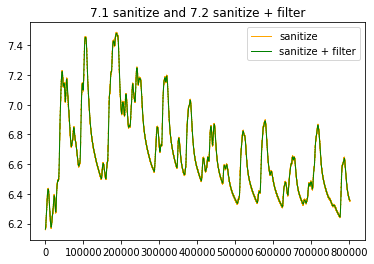

In [83]:
# SCR does not use any baseline corrected signals
amp_min = 0.01
scr_signal = nk.signal_sanitize(
    physio_df['physio_eda'])
scr_filters = nk.signal_filter(scr_signal, 
                               sampling_rate=samplingrate, 
                               highcut=1, method="butterworth", order=2)
figure, ax1 = plt.subplots()
ax1.title.set_text('7.1 sanitize and 7.2 sanitize + filter')
l1 = ax1.plot(scr_signal, linewidth=1, zorder=1, label="sanitize", color="orange")
l2 = ax1.plot(scr_filters, linewidth=1, zorder=1, label="sanitize + filter", color="green")
ax1.legend(handles=[ l1[0], l2[0]])

### 6.3 detrend

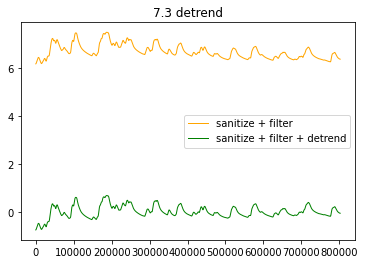

In [84]:
scr_detrend = nk.signal_detrend(scr_filters)
figure, ax1 = plt.subplots()
ax1.title.set_text('7.3 detrend')
# l1 = ax1.plot(run_df["EDA_corrected_02fixation"], linewidth=1.5, zorder=1, label="baseline corrected", color="gray")
l1 = ax1.plot(scr_filters, linewidth=1, zorder=1, label="sanitize + filter", color="orange")
l2 = ax1.plot(scr_detrend, linewidth=1, zorder=1, label="sanitize + filter + detrend", color="green")
ax1.legend(handles=[l1[0], l2[0]])

### 6.4 decompose EDA signal (tonic/phasic)

Text(0.5, 1.0, '7.4 decomposition of the eda signals: tonic & phasic')

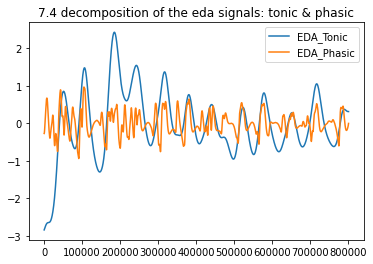

In [85]:

scr_decomposed = nk.eda_phasic(nk.standardize(scr_detrend), 
                               sampling_rate=samplingrate) 
scr_decomposed_plot = scr_decomposed.plot()

scr_peaks, info = nk.eda_peaks(scr_decomposed["EDA_Phasic"].values,
                               sampling_rate=samplingrate, 
                               method = "neurokit", amplitude_min = 0.02)  
scr_signals = pd.DataFrame({"EDA_Raw": scr_signal, "EDA_Clean": scr_signal})
scr_processed = pd.concat([scr_signals, scr_decomposed, scr_peaks], axis=1) 
# eda_level_signal = eda_processed["EDA_Tonic"] # for skin conductance level
plt.title("7.4 decomposition of the eda signals: tonic & phasic")

Text(0.5, 1.0, "Let's check the alignment of the condition types and the tonic/phasic signals")

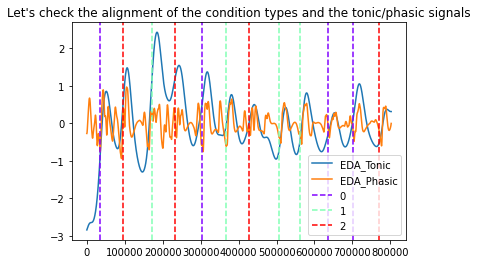

In [86]:
plot_eda_phasic = nk.events_plot(event_stimuli, 
                                 scr_processed[["EDA_Tonic", "EDA_Phasic"]])
plt.title("Let's check the alignment of the condition types and the tonic/phasic signals")


### 6.5 epochs_create
> Lastly, we need to create epochs based on the start of the stimulus and also designate the start and end of the event. 
* In this example, we time-lock it to the start of the pain plateau, i.e. the 2nd TTL, because we have precision of the pain heat stimulus. 
* Because we're dealing with phasic activity, we also limit the time span of this signal to the duration of the plateau, i.e. 5 seconds. 

In [87]:
scr_epochs = nk.epochs_create(scr_processed,
                              event_stimuli,
                              sampling_rate=samplingrate,
                              epochs_start=0,
                              epochs_end=5,
                              baseline_correction=True) 
scr_epochs[2] # produces a dictionary per trial (in this example, 12 keys, and 10000 rows, i.e. 5 seconds with 14 columns related to SCR data)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime,Index,Label,Condition
0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,high_stim
0.0005,-0.001526,-0.001526,0.000160,-0.000104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,high_stim
0.0010,-0.003052,-0.003052,0.000319,-0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,high_stim
0.0015,-0.003052,-0.003052,0.000479,-0.000312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2,high_stim
0.0020,0.000000,0.000000,0.000639,-0.000416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2,high_stim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.9980,0.186157,0.186157,1.030967,-0.240953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9995.0,2,high_stim
4.9985,0.186157,0.186157,1.031001,-0.240904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9996.0,2,high_stim
4.9990,0.186157,0.186157,1.031035,-0.240856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9997.0,2,high_stim
4.9995,0.184631,0.184631,1.031070,-0.240807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9998.0,2,high_stim


### 6.6 eda_eventrelated

* event-related analysis
* of interest especially when analyzing EDA responses to specific stimuli
* returns:
   * EDA_SCR: Skin Conductance Response yes (1) or no (0) -> if yes, corresponding components are listed
   * EDA_Peak_Amplitude: maximum amplitude of phasic component of signal
   * SCR_Peak_Amplitude: peak amplitude of the first SCR in each epoch (parameter of interest if related to specific stimulus)
   * SCR_Peak_Amplitude_Time: timpepoint of each first SCR peak amplitude (peak should occur within 2-7 s after stimulus onset)
   * SCR_RiseTime: risetime of each first SCR (time it takes for SCR to reach peak amplitude from onset)
   * SCR_RecoveryTime: half-recovery time of each first SCR (time it takes for SCR to decrease to half amplitude)

In [88]:
scr_phasic = nk.eda_eventrelated(scr_epochs)
scr_phasic # produces a dataframe with 12 trials and average information: EDA_Peak_Amplitude	EDA_SCR	SCR_Peak_Amplitude	SCR_Peak_Amplitude_Time	SCR_RiseTime	SCR_RecoveryTime

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,med_stim,0.0,1.645311,0,NaN,NaN,NaN,NaN
1,1,low_stim,0.0,0.585128,1,1.330514,0.201020,2.7970,NaN
2,2,high_stim,0.0,0.125666,1,0.340693,2.555256,1.6145,230.0
3,3,low_stim,0.0,0.414831,1,0.791171,4.194419,2.4425,6.0
4,4,med_stim,0.0,1.100837,1,1.292173,4.714471,3.0445,NaN
5,5,high_stim,0.0,1.046483,0,NaN,NaN,NaN,NaN
6,6,low_stim,0.0,0.480728,1,0.153858,0.025503,1.4180,1603.0
7,7,high_stim,0.0,0.747126,0,NaN,NaN,NaN,NaN
8,8,high_stim,0.0,0.640206,0,NaN,NaN,NaN,NaN
9,9,med_stim,0.0,0.270397,0,NaN,NaN,NaN,NaN


# We're done with the SCR Phasic signal extraction! 🥳
All we need to do is save this!

---

## Skin Conductance Level (SCL) Tonic 💻 `preprocess.extract_SCL`

> #### **eda tonic**
* interval-related analysis
* of interest for longer time periods, also resting-state (input could therefore also be a whole condition instead of snipped-out epochs)
* returns:
   * SCR_Peaks_N: number of occurrences of Skin Conductance Response
   * SCR_Peaks_Amplitude_Mean: mean amplitude of SCR peak occurrences

> #### **eda level**
* analysis of skin conductance level

> NOTE:
* For the tonic signals, note that we need baseline corrected signals. Other than that, we'll use very similar steps to SCR phasic: 
* signal ➔ filters ➔ detrend ➔ decompose.
* The difference is that we'll use the `tonic` signals from the decomposed stage, and feed them into a neurokit function `epochs_create`

In [93]:
SCL_epoch_start = -1; SCL_epoch_end = 20

In [94]:
tonic_length, scl_raw, scl_epoch = utils.preprocess.extract_SCL(df=physio_df_bl,
                        eda_col='physio_eda_blcorrect', event_dict=event_stimuli, samplingrate=2000,
                        SCL_start=SCL_epoch_start, SCL_end=SCL_epoch_end, baseline_truefalse=False)


## NOTE: `preprocess.extract_SCL` is a series of neurokit functions.
> We've compacted into a function, but feel free to use the functions directly from neurokit.
> ```
  tonic_epoch_start = -1
    tonic_epoch_end = 8
    tonic_length = np.abs(tonic_epoch_start-tonic_epoch_end) * samplingrate
    scl_signal = nk.signal_sanitize(physio_df['EDA_corrected_02fixation'])
    scl_filters = nk.signal_filter(scl_signal,
                                sampling_rate=samplingrate,
                                highcut=1,
                                method="butterworth",
                                order=2)  
    scl_detrend = nk.signal_detrend(scl_filters)
    scl_decomposed = nk.eda_phasic(nk.standardize(scl_detrend),
                                sampling_rate=samplingrate)
    scl_signals = pd.DataFrame({
        "EDA_Raw": scl_signal,
        "EDA_Clean": scl_filters
    })
    scl_processed = pd.concat([scl_signals, scl_decomposed['EDA_Tonic']],
                            axis=1)
    try:
        scl_epoch = nk.epochs_create(scl_processed['EDA_Tonic'],
                                    event_stimuli,
                                    sampling_rate=samplingrate,
                                    epochs_start=tonic_epoch_start,
                                    epochs_end=tonic_epoch_end,
                                    baseline_correction=False)
```


  

> 🎨 Let's plot the `scl_raw` output. It would be a dictionary, per Neurokit's output scheme. We'll plot the first signal, from the first trial, medium intensity, spanned across 21 seconds. 

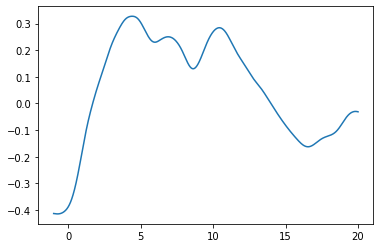

In [98]:
scl_raw[0]['Signal'].plot()

> 🎨 Let's plot the `scl_epoch` output. It would be a dictionary, per Neurokit's output scheme. We'll plot the first signal, from the first trial, medium intensity, spanned across 21 seconds. 

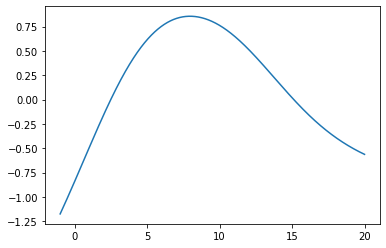

In [99]:
scl_epoch[0]['Signal'].plot()


> And finally, plot all trials.
* imagine doing this on a group level basis!
* Given that this is a dictionary from a single run, now you can do this iteratively for all the runs and do a group analysis.

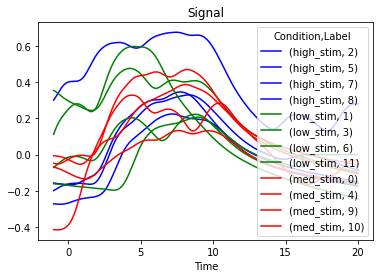

In [100]:
plot_level = nk.epochs_plot(scl_raw)

#### Last step is to save `scl_raw` and also the scl_epoch. In addition.... 

> ## 💻 `utils.preprocess.combine_metadata_SCL`
* We can also grab the mean_signal from scl_epoch and save is a more compact dataframe.
* I have a function for that!

In [103]:
metadata_SCL = utils.preprocess.combine_metadata_SCL(scl_epoch, metadf_dropNA, total_trial = 12)

In [104]:
metadata_SCL

,trial_order,iv_stim,mean_signal
0,1,med_stim,0.158465
1,2,low_stim,0.433369
2,3,high_stim,1.642057
3,4,low_stim,0.867144
4,5,med_stim,0.700344
5,6,high_stim,0.20206
6,7,low_stim,0.120246
7,8,high_stim,-0.117506
8,9,high_stim,0.25648
9,10,med_stim,-0.064399


# We're also done extracting SCR tonic signals 🥳 Save this to a file :) 